# Intro:

This notebook is the second in the series for the Capstone Project.  "Capstone_Data-Prep" covers pulling in several
data sources, trimming to the needed observations/variables, joining together, and producing the source data or this
notebook.

In [173]:
# Standard Libraries
import pandas as pd
import numpy as np
import os
import warnings
import json
import math

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn Data Prep:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#sklearn Imputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# SkLearn Measurement Libraries:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score

# SkLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# set Theme
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [174]:
# Set Paths
path = os.getcwd()
sourceDataPath = path + '\\CleanData\\'
exportPath = path +'\\Export\\'
plotLoc = 'C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/'

# set plot export paths:


print(f"Source Data:",sourceDataPath)
print(f"Exports:",exportPath)
print(f"Plots:",plotLoc)

Source Data: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\CleanData\
Exports: C:\Users\TheCu\OneDrive\Documents\Grad-School-Docs\CapstoneProject\Repo\Export\
Plots: C:/Users/TheCu/OneDrive/Documents/Grad-School-Docs/CapstoneProject/Repo/Export/


# Reusable Functions:

In [175]:
# Takes a DF and Producecs a Report of Null Values
def nullAnalysis(df):
    row = []
    null_summaryDF = pd.DataFrame(columns = ["Variable","Observations","Nulls","Null_Per",
                                             "Num_Unique","Type"])
    for column in df:
        var = column
        countOfObs = len(df[var])
        countOfNull = df[var].isnull().sum()
        perOfNull = round((100 * countOfNull) / countOfObs,3)
        numUnique = df[var].nunique()
        type  = df[var].dtypes
        # Append to Summary DF
        row = [var, countOfObs,countOfNull,perOfNull,numUnique,type]
        df_length = len(null_summaryDF)
        null_summaryDF.loc[df_length] = row
    # Get Summary Stats
    countofVars = len(null_summaryDF)
    countofNotNull = (null_summaryDF['Nulls'] == 0).sum()
    countofNull = (null_summaryDF['Nulls'] != 0).sum()
    print(f"Count of Variables:",countofVars)
    print(f"Count of Variables without nulls:",countofNotNull)
    print(f"Count of Variables with null :",countofNull)
    # Format Summary
    summaryDF = null_summaryDF[null_summaryDF['Nulls'] != 0].sort_values(by=['Nulls'],ascending=False)
    return summaryDF

In [176]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df,scaleList):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in scaleList:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = round(df_std[column],5)
    return df_std

In [177]:
#  Split function - Takes a df and list of predictor vars and specified response var and
##  returns x/y test/train sets.
## Note: update params if you want reproducable splits or not
## Note: set test size to 20%

def testTrainSplit (df, PredictorVar,ResponseVar):
    # Split into training/test
    x = df[PredictorVar]
    y = df[ResponseVar]
    # Split Data Set Seed NP Random
    np.random.seed(1) # seed np random
    ## split data - use "random_state = any number (42) if you want reproducable splits.
    ### Remove random-state if you want random
    x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42, test_size = 0.2)
    return x_train, x_test, y_train, y_test


In [178]:
# Takes a model, and test sets and returns and ROC Curve w/ AUC value

def ROC_Curve_Plot(model,roc_x_test,roc_y_test):
    #new section
    #old section
    probas = model.predict_proba(roc_x_test) # get the probability distribution
    fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    roc_auc = auc(fpr, tpr) # get area under curve
    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    return plt

# Source: https://medium.com/@gaurav_bio/making-sense-of-real-world-data-roc-curves-and-when-to-use-them-90a17e6d1db

In [179]:
# Takes a model and various split sets and returns a CM plot w/ Accuracy

def createConfMatrix (regObj, y_test, y_pred, x_test):
    # Logistic Regression -- Step 5 -- Create Confusion Matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cm.columns.name = 'Predicted'
    cm.index.name = 'True'
    # Logistic Regression -- Step 6 -- Calc Accuracy From Test Set
    score = regObj.score(x_test, y_test)
    score = round(score,4)
    return cm, score

In [180]:
# Takes test and predicted sets and returns precision/recall metrics
def summaryStats (model_name, y_test, y_pred, SummaryDF):
    # Collect Stats
    row =[]
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    f1 = round(f1_score(y_test, y_pred),4)
    #probas = model.predict_proba(roc_x_test) # get the probability distribution
    #fpr, tpr, thresholds = roc_curve(roc_y_test, probas[:,0], pos_label=0) # get false and true positive rates
    #roc_auc = auc(fpr, tpr) # get area under curve
    # Collect Results
    row = [model_name,accuracy, precision, recall, f1]
    # append stats to Summary Stats DF
    df = SummaryDF
    df_length = len(df)
    df.loc[df_length] = row
    return df

In [181]:
# Takes a model and returns a Feature Importance Plot

def FeatureImportance (model,featureList):
    # Best Tree-- Plot Most Important Features
    importances = model.feature_importances_
    #Convert Array to DF
    feature_importances = pd.Series(importances, index=featureList)
    feature_importances = feature_importances.to_frame().reset_index()
    feature_importances = feature_importances.rename(columns={'index':'feature',0:'impDecrease'})
    feature_importances = feature_importances.sort_values(by='impDecrease',ascending=False)
    #std = np.std([tree.feature_importances_ for tree in cv_bestTree.estimators_], axis=0)
    # Create Plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize = (6,6), dpi=200)
    ax = sns.barplot(x="impDecrease", y="feature", data=feature_importances,color="blue")
    ax.set_title("Feature importance")
    ax.set_ylabel("Feature")
    ax.set_xlabel("Impurity Decrease")
    fig.tight_layout()
    return feature_importances, fig

In [182]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [183]:
def grid_search_wrapper(refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(x_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

# Get and Prep Data

In [184]:
# Get Source Data
file = 'completeDF.csv'
origDF = pd.read_csv(sourceDataPath+file,skipinitialspace = True)
origDF = origDF.drop(columns=['Unnamed: 0'])
origDF.shape

(348, 167)

In [185]:
nullAnalysisDF = nullAnalysis(origDF)
nullAnalysisDF


Count of Variables: 167
Count of Variables without nulls: 45
Count of Variables with null : 122


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
166,SettlementAmount,348,302,86.782,12,float64
141,xacc_std,348,83,23.851,257,float64
65,esubc_std,348,73,20.977,70,float64
140,xacc,348,50,14.368,284,float64
79,intpn_std,348,49,14.080,276,float64
...,...,...,...,...,...,...
114,pstk,348,1,0.287,49,float64
110,ppegt,348,1,0.287,328,float64
48,dpact,348,1,0.287,326,float64
18,ceq,348,1,0.287,347,float64


In [186]:
# Set aside variables that may be valuable for looks/interpretation of results, but not modeling
orig_lookUps = origDF[['gvkey','tic','curncd','currtr']].copy()

# delete those from origDF
origDF = origDF.drop(columns=['tic','curncd','currtr'])
orig_lookUps.head(3)

,gvkey,tic,curncd,currtr
0,1239,ACV,USD,1.0
1,1266,ALCO,USD,1.0
2,1408,BEAM,USD,1.0


In [187]:
# Scale Data -- Create List for Scaling

## Create list of exceptions for scaling
scaleException = ['gvkey','gsubind','exesign','src','auop','rest_count','rest_count_of_diffs','rest_a_count_of_diffs',
                  'st_per_growth','st_per_currentToMax','st_per_lowToStart','st_volatility','rat_spcsrc',
                  'lawsuit','SettlementAmount',
                  'invch']

## Remove exceptions from scale list
orig_scaleList = origDF.columns.tolist()
for col in scaleException:
    orig_scaleList.remove(col)

# Scale Data -- Call the z_score function
origDF_scaled = z_score(origDF,orig_scaleList)
origDF_scaled.sample(3)



,gvkey,exesign,src,auop,gsubind,aoloch,aoloch_std,at,at_std,bkvlps,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
162,30436,1,53,1,30201030,NaN,NaN,-0.21588,0.29479,-0.07859,...,0.21,-0.12927,-0.12920,0.09337,-0.02173,-0.12956,-0.14794,0.0,0.0,NaN
282,178859,1,53,2,30302010,-0.05579,NaN,-0.33834,NaN,-0.07865,...,1.00,-0.31079,-0.31073,-0.29814,-0.22835,-0.08134,-0.06528,0.0,0.0,NaN
228,137884,1,5,2,30201030,-0.06200,-0.38893,-0.33839,-0.38189,-0.07865,...,0.00,-0.12927,-0.12920,-0.29814,-0.22835,-0.09881,-0.05368,2.0,0.0,NaN


In [188]:
#Imputer 1 - Prep DF for Imputer
#TODO:
## Determine method to test how well it did
## Create Visuals to explain what it did.


# Used as a guide, which states that ExtraTreesRegressor performs best:
## https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505
## Further Documentation: https://scikit-learn.org/stable/modules/impute.html#impute

## Create DF w/o response Vars and a temp to rejoin after imputer runs
completeDF_Imputed = origDF_scaled.copy()
temp_Imputed_Resp = completeDF_Imputed[['gvkey','lawsuit','SettlementAmount']]
completeDF_Imputed = completeDF_Imputed.drop(columns=['lawsuit','SettlementAmount'])
temp_Imputed_Resp.head(3)

,gvkey,lawsuit,SettlementAmount
0,1239,1.0,0.0
1,1266,0.0,NaN
2,1408,0.0,NaN


In [189]:
# Imputer 2 - Run Imputer & Rejoin Temp Data

print("Starting Imputer...")

# Introduce IterativeImputer with an estimator and Fit
imp = IterativeImputer(estimator=ExtraTreesRegressor(), max_iter=10, random_state=42)
imp.fit(completeDF_Imputed)

# Transform the dataset containing missing values
completeDF_Imputed = pd.DataFrame(imp.transform(completeDF_Imputed), columns = completeDF_Imputed.columns)
print("Done w/ Imputer")

# Rejoin Temp - Check Shape, should be 348, 164
completeDF_Imputed = completeDF_Imputed.merge(temp_Imputed_Resp, left_on='gvkey', right_on='gvkey')
completeDF_Imputed.shape

Starting Imputer...
Done w/ Imputer


(348, 164)

In [190]:
# Fix Features That Should be Int w/o decimals
cols = ['gvkey','exesign','src','auop','rat_spcsrc','lawsuit']
completeDF_Imputed[cols] = completeDF_Imputed[cols].astype(int)
completeDF_Imputed.sample(3)

,gvkey,exesign,src,auop,gsubind,aoloch,aoloch_std,at,at_std,bkvlps,...,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit,SettlementAmount
322,187581,0,88,2,30202010.0,-0.07060,-0.218226,-0.32819,-0.004421,-0.088538,...,0.7689,0.034544,0.125325,-0.041551,0.005936,0.063034,0.14857,0,0,NaN
101,13456,1,5,2,30202030.0,-0.05530,-0.399840,-0.33843,-0.382680,-0.078650,...,1.3600,-0.129270,-0.129200,-0.298140,-0.228350,-0.228190,-0.08432,0,0,NaN
55,8815,1,5,1,30101030.0,-0.11579,-0.326480,0.27446,0.387940,-0.078580,...,0.9700,-0.129270,-0.129200,-0.265220,0.044370,-0.149470,-0.14124,7,0,NaN


In [191]:
# Check Result Nulls
nullAnalysisDF = nullAnalysis(completeDF_Imputed)
nullAnalysisDF

Count of Variables: 164
Count of Variables without nulls: 163
Count of Variables with null : 1


,Variable,Observations,Nulls,Null_Per,Num_Unique,Type
163,SettlementAmount,348,302,86.782,12,float64


# LawSuit Modeling

Note to self: In my process, before I ran this section I ran the "Feature Selection" section to trim the
feature list.  That section is archived below, but it made sense to place it below this modeling section
because I did not need to re-run.  The results are saved in the "Export" directory and were used to produce
the feature list at the top of this section.

In [191]:
# Start here: recreate modeling and reduce based on feature list then split and smote
# Next intial model selection

In [192]:
break

# Feature Selection
* Creates a Test/Train Split (Will Resplit from Source After Feature Selection)
* Then uses Random Forest and Grad Boost for Feature Importance
* Was Originally run before modeling.  Results reflected in feature lists for model and stored as reports
and plots in the export directory


In [193]:
# Prepare For Feature Selection

## Create copy of cleanDF
tempModelingDF = completeDF_Imputed.copy()
## Feature Selection Will Use Lawsuit - so drop SettlementAmount
tempModelingDF = tempModelingDF.drop(columns='SettlementAmount')
print(f"Shape:",tempModelingDF.shape)

## Set gvkey as index
tempModelingDF = tempModelingDF.set_index('gvkey')
tempModelingDF.sample(3)

Shape: (348, 163)


,exesign,src,auop,gsubind,aoloch,aoloch_std,at,at_std,bkvlps,bkvlps_std,...,st_per_lowToStart,st_volatility,sec_ajexm,sec_ajpm,sec_trfm_mean,sec_trfm_std,sec_trt1m_mean,sec_trt1m_std,rat_spcsrc,lawsuit
gvkey,,,,,,,,,,,,,,,,,,,,,
6573,1,5,1,30202030.0,-0.07708,-0.36938,-0.30611,-0.36141,-0.07851,-0.07691,...,-0.13,0.19,-0.12927,-0.1292,0.56581,0.15016,-0.12329,-0.15219,4,0
190262,1,5,2,30201020.0,-0.05841,-0.39569,-0.33829,-0.38103,-0.07865,-0.07692,...,-0.90,0.72,-0.12927,-0.1292,-0.29814,-0.22835,-0.17267,-0.12957,0,0
160196,1,5,1,30202030.0,-0.06022,-0.37725,-0.32623,-0.35400,-0.07861,-0.07691,...,-0.80,0.48,-0.12927,-0.1292,-0.24184,-0.22835,-0.14444,-0.14229,0,0


In [194]:
# Set or Reset Test/Train Split
# Params
df=tempModelingDF
ResponseVar = 'lawsuit'
PredictorVar_orig = df.columns.values.tolist()
PredictorVar_orig.remove(ResponseVar)

# Function Call To prep train/test
x_train, x_test, y_train, y_test  = testTrainSplit(df, PredictorVar_orig, ResponseVar)
print(f"x_train shape:",x_train.shape)
print(f"x_test shape:",x_test.shape)

x_train shape: (278, 161)
x_test shape: (70, 161)


In [195]:
#TODO - check params with .get_params
# maybe add ration and check knn
# Class Balancing
print('*******************************************************************************')
print("Before Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')
sm = SMOTE(random_state=2)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('*******************************************************************************')
print("After Balancing:")
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print()
print(f"y_train value counts:",y_train.value_counts())
print('*******************************************************************************')

*******************************************************************************
Before Balancing:
x_train shape:  (278, 161)
y_train shape:  (278,)
x_test shape:  (70, 161)
y_test shape:  (70,)

y_train value counts: 0    243
1     35
Name: lawsuit, dtype: int64
*******************************************************************************
*******************************************************************************
After Balancing:
x_train shape:  (486, 161)
y_train shape:  (486,)
x_test shape:  (70, 161)
y_test shape:  (70,)

y_train value counts: 1    243
0    243
Name: lawsuit, dtype: int64
*******************************************************************************


In [196]:
# Create DF for Capturing Model Results
statRow = []
summaryStatsDF = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall','F1'])

## Feature Selection -- Random Forest

In [197]:
print("starting RF")
# Random Forest
## Set and Fit Model
rf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=96, min_samples_split=2, max_depth=20,
                            max_features='sqrt',criterion='gini',n_jobs=-1)

rf.fit(x_train,y_train)

## Make Predictions
y_pred_rf = rf.predict(x_test)
print("done RF")

starting RF
done RF


In [198]:
rf.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': 96,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

start plot


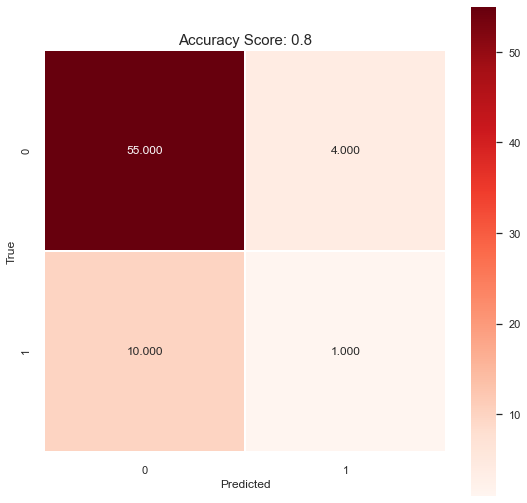

In [199]:
print("start plot")
cm, score = createConfMatrix(rf,y_test, y_pred_rf, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'RF_CM_LS_FeatSelect.png')

In [200]:
# Random Forest -- Precision/Recall Scores

## Set Params
model_name = "Random Forest"

## Call Function
summaryDF = summaryStats(model_name,y_test,y_pred_rf, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.8,0.2,0.0909,0.125


Start RF ROC Plot


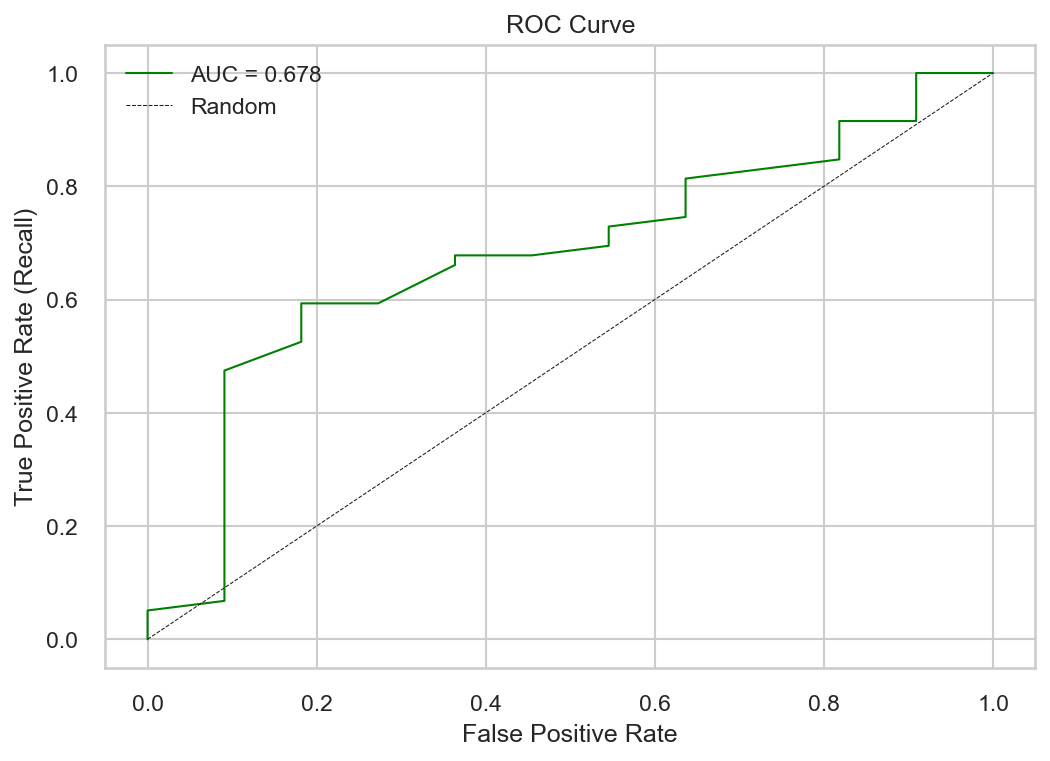

In [201]:
# ROC Curve/ AUC Score
print("Start RF ROC Plot")

## Call Function
ROC_Curve_Plot(rf,x_test, y_test) # model, x_test, y_test
plt.show()
#plt.savefig(plotLoc+'RF_ROC.png')

Start RF Feature Importance


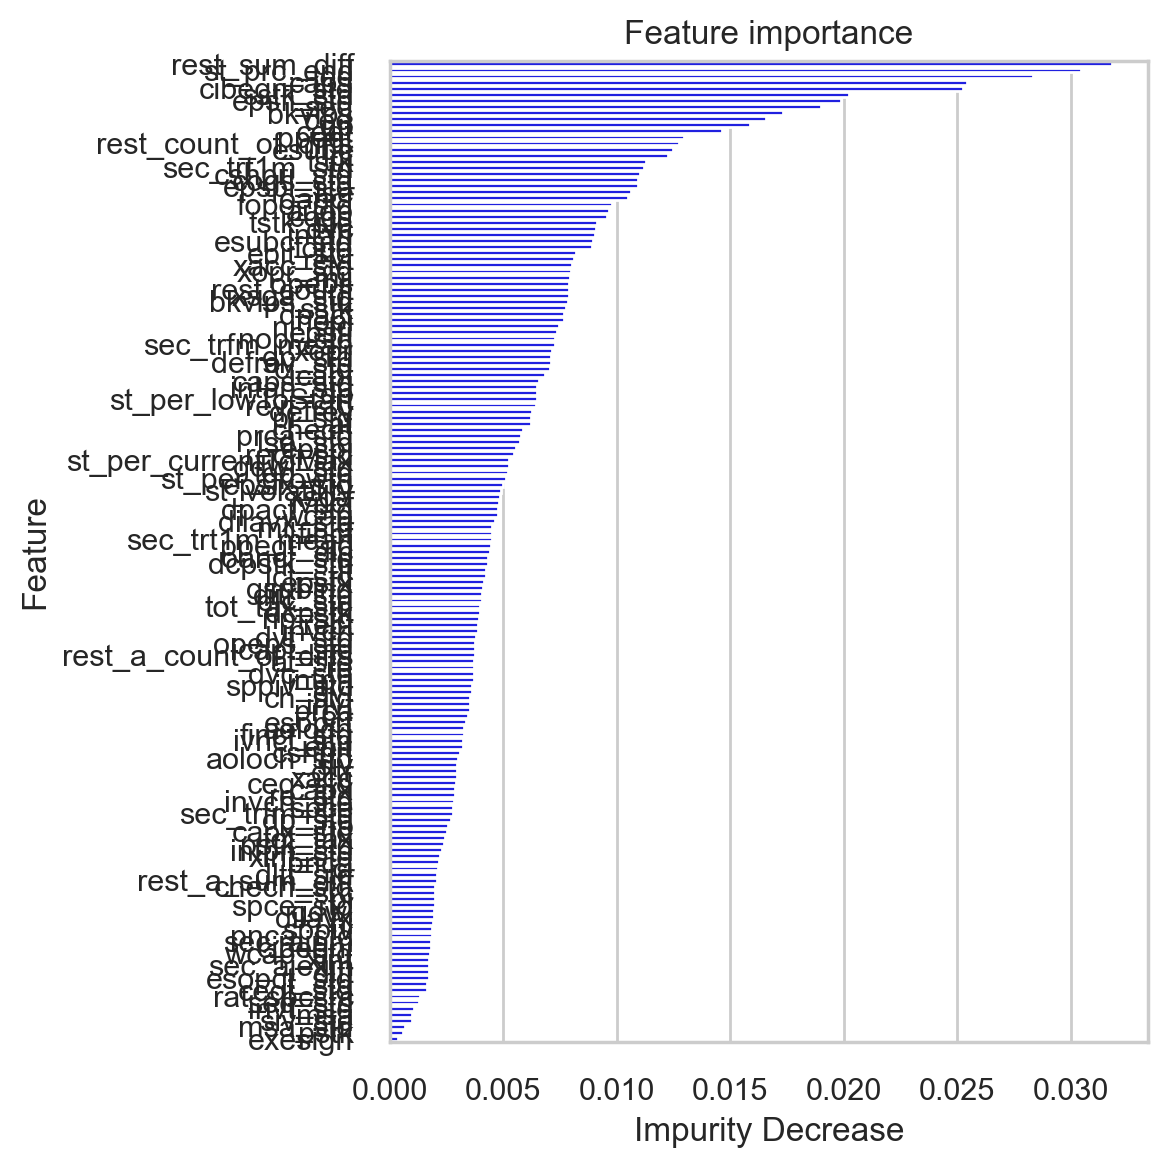

In [202]:
# Random Forest -- Feature Importance -- Plot Most Important Features
print("Start RF Feature Importance")
featureList = x_train.columns.to_list()
feature_importances, fig = FeatureImportance(rf,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'RF_LS_FeatSelect.png')

## Gradient Boosting

In [203]:
print("starting GB")
## Setting when optimized for Accuracy
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,random_state=1,
                                max_depth=10, min_samples_split=75, max_features=8)

gb.fit(x_train,y_train)

## Make Predictions
y_pred_gb = gb.predict(x_test)
print("done predict gb")

starting GB
done predict gb


In [204]:
gb.get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.5,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 8,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 75,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

start gb plot


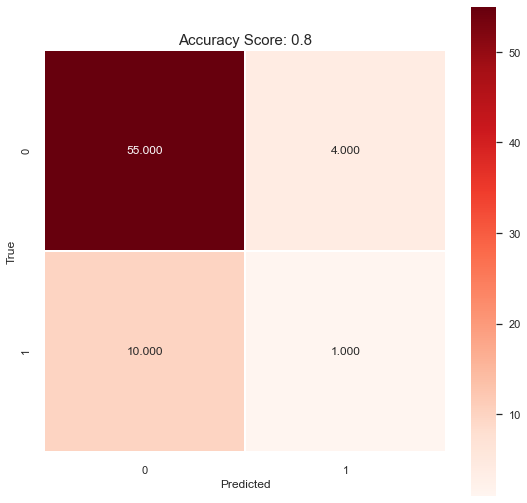

In [205]:
print("start gb plot")
cm, score = createConfMatrix(gb,y_test, y_pred_gb, x_test) # model, y_test, y_pred, x_test

# plot result
plt.figure(figsize=(9,9))
fig= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Reds');
all_sample_title = "Accuracy Score: " + score.astype('str')
plt.title(all_sample_title, size = 15);
plt.savefig(plotLoc+'GB_CM_LS_FeatSelect.png')

In [206]:
#  GB -- Precision/Recall Scores

## Set Params
model_name = "Gradient Boost - Tuned for Accuracy"

## Call Function
summaryDF = summaryStats(model_name,y_test, y_pred_gb, summaryStatsDF) # modelName(str), y_test, y_pred, df
summaryDF

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.8,0.2,0.0909,0.125
1,Gradient Boost - Tuned for Accuracy,0.8,0.2,0.0909,0.125


Start GB ROC Plot


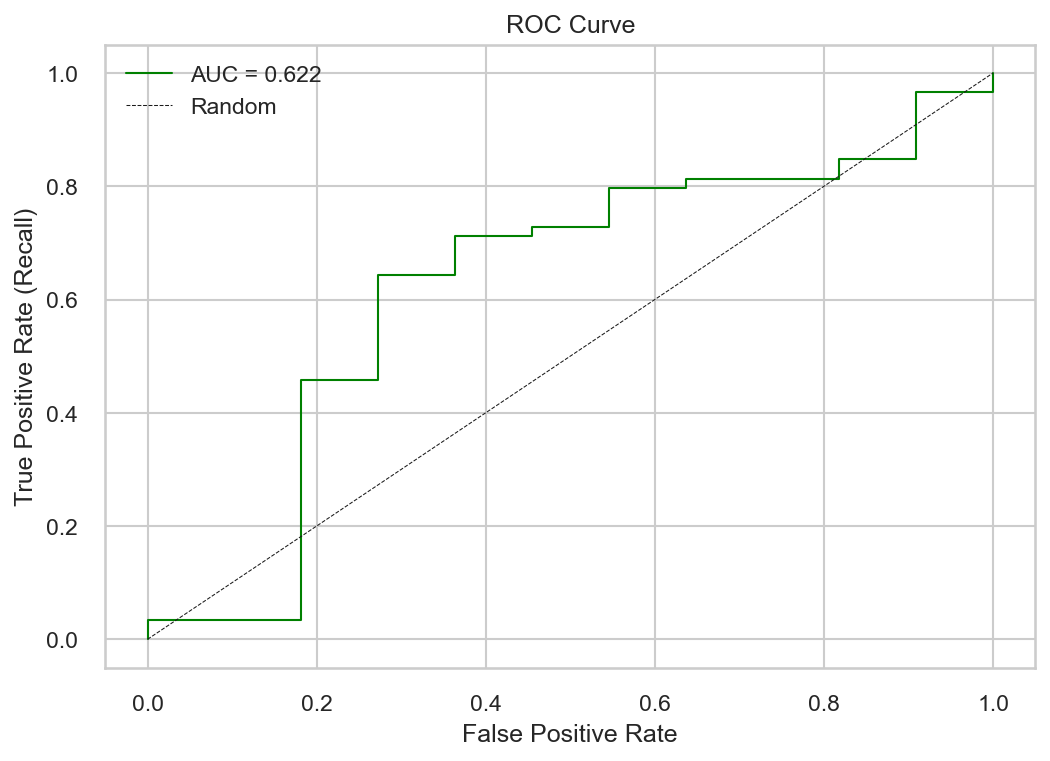

<Figure size 576x396 with 0 Axes>

In [207]:
# ROC Curve/ AUC Score
print("Start GB ROC Plot")

## Call Function
ROC_Curve_Plot(gb,x_test, y_test) # model, x_test, y_test
plt.show()
plt.savefig(plotLoc+'GB_ROC_LS_FeatSelect.png')

Start GB Feature Importance


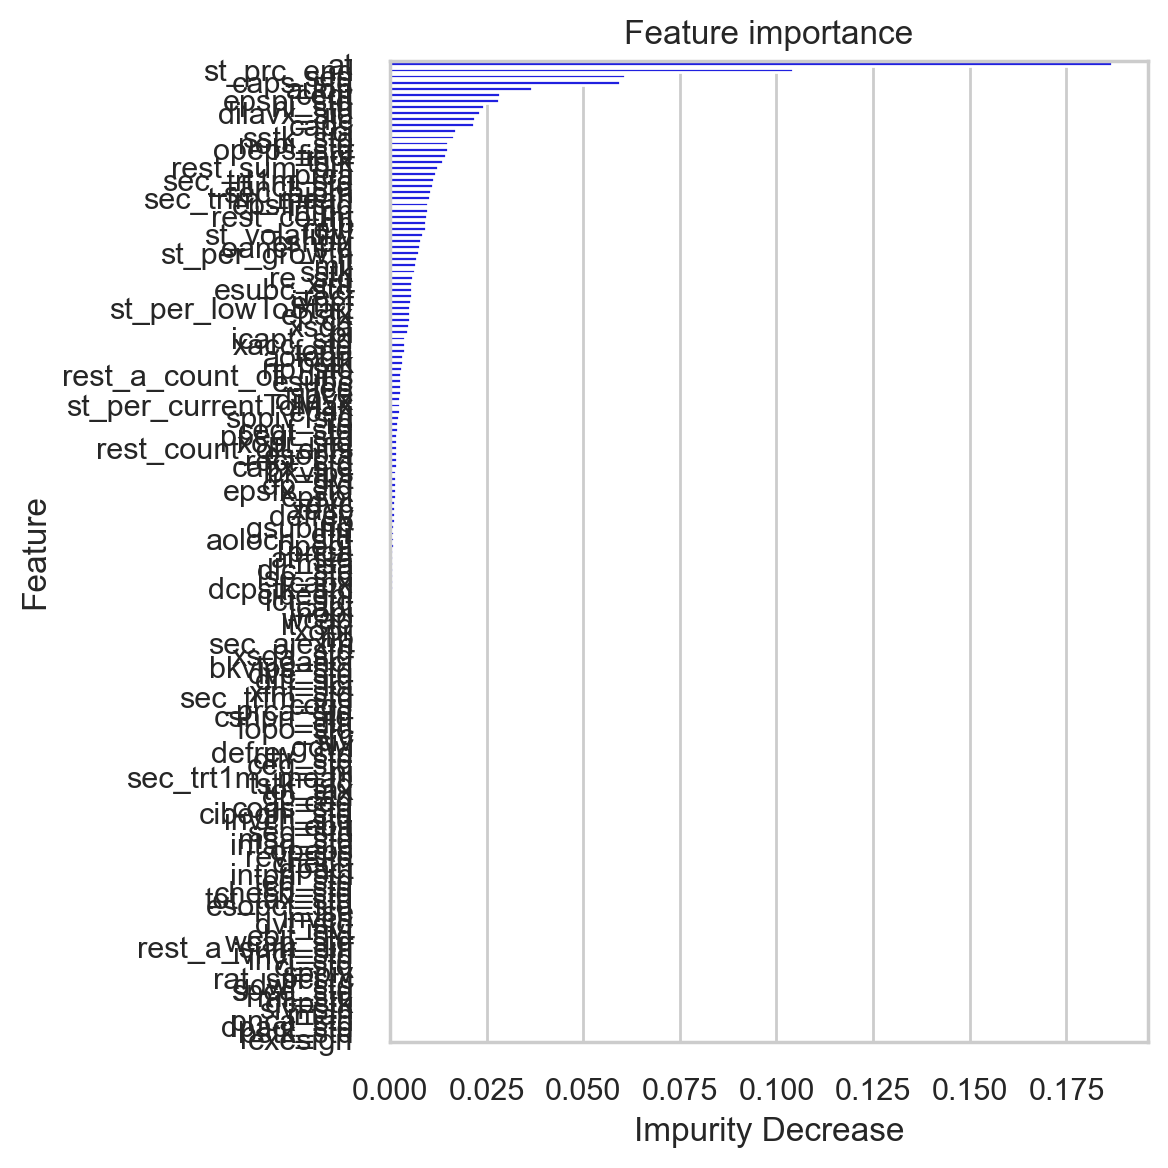

In [208]:
# Gradiant Boost -- Feature Importance -- Plot Most Important Features
print("Start GB Feature Importance")

feature_importances, fig = FeatureImportance(gb,featureList) #model, featureList
fig.show()
plt.savefig(plotLoc+'GB__LS_FeatSelect.png')

In [209]:
## Combined Feature Importance Plot

rf_importances = rf.feature_importances_
rf_forest_importances = pd.Series(rf_importances, index=featureList)
rf_forest_importances = rf_forest_importances.to_frame().reset_index()
rf_forest_importances = rf_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
rf_forest_importances = rf_forest_importances.sort_values(by='impDecrease',ascending=False)
rf_forest_importances['Model'] = "Random Forest"

gb_importances = gb.feature_importances_
gb_forest_importances = pd.Series(gb_importances, index=featureList)
gb_forest_importances = gb_forest_importances.to_frame().reset_index()
gb_forest_importances = gb_forest_importances.rename(columns={'index':'feature',0:'impDecrease'})
gb_forest_importances = gb_forest_importances.sort_values(by='impDecrease',ascending=False)
gb_forest_importances['Model'] = "Gradient Boosting"
feature_importances_comb = rf_forest_importances.append(gb_forest_importances, ignore_index=True)

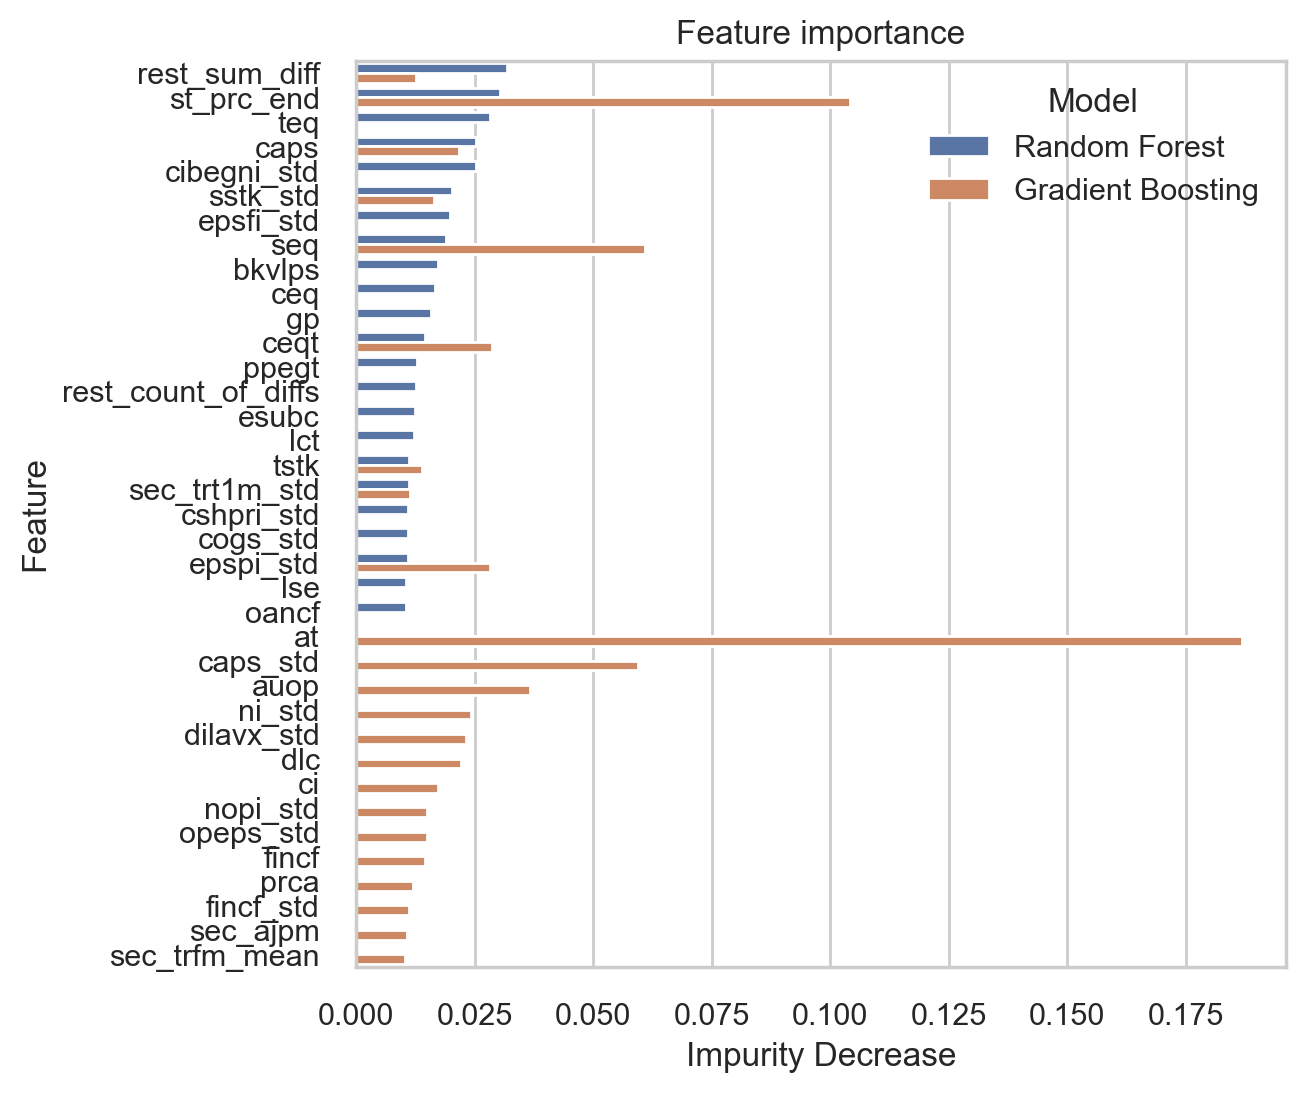

In [210]:
## Feature Importance -- Combined Plot

index_names = feature_importances_comb[feature_importances_comb['impDecrease'] <= 0.01 ].index

# drop these row indexes
# from dataFrame
feature_importances_comb.drop(index_names, inplace = True)
feature_importances_comb

# Create Plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize = (6,6), dpi=200)
ax = sns.barplot(x="impDecrease", y="feature", hue="Model",
                  data=feature_importances_comb)
#plt.vlines(x = 0.01, ymin = -1, ymax = 17.0, color = 'black', linewidth=1)
ax.set_title("Feature importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Impurity Decrease")

plt.savefig(plotLoc +'Combined_LS_FeatSelect.png')

In [211]:
print(f"feature importance shape:",feature_importances_comb.shape)


featImport_ManAppend = {'feature': 'rat_spcsrc', 'impDecrease': 0.001111, 'Model': 'Manual Addition'}
feature_importances_comb = feature_importances_comb.append(featImport_ManAppend,ignore_index=True)
feature_importances_comb.to_excel(exportPath+"FeatureSelection_LawSuit.xlsx")
feature_importances_comb

feature importance shape: (46, 3)


,feature,impDecrease,Model
0,rest_sum_diff,0.031804,Random Forest
1,st_prc_end,0.030451,Random Forest
2,teq,0.028339,Random Forest
3,caps,0.025409,Random Forest
4,cibegni_std,0.025231,Random Forest
5,sstk_std,0.020214,Random Forest
6,epsfi_std,0.019867,Random Forest
7,seq,0.019013,Random Forest
8,bkvlps,0.017305,Random Forest
9,ceq,0.016572,Random Forest


# Lawsuit -- Initial Model Evaluation

In [212]:
break

SyntaxError: 'break' outside loop (<ipython-input-212-6aaf1f276005>, line 1)

# Model Tuning

## RF Tuning

In [ ]:
rf.get_params(deep=True)

In [ ]:
clf = RandomForestClassifier(verbose=2)

param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'max_depth': [3,5,10,20],
    'n_estimators': [100,500,1000],
    'max_leaf_nodes':[16,32,64,96],
    'criterion':['gini','entropy']
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
print("starting...")
grid_search_clf = grid_search_wrapper(refit_score='accuracy_score')
grid_search_clf

RF_Best_Params = grid_search_clf.best_params_

# Write REport
RF_Best_Params = {'exDict': RF_Best_Params}

with open('RF_Best_Params.txt', 'w') as file:
     file.write(json.dumps(RF_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = rf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'RRF_Decision-Thresh.png')

## GB Tuning

In [ ]:
gb.get_params(deep=True)

In [ ]:
clf = GradientBoostingClassifier(verbose=2)

param_grid = {
    'min_samples_split': [10,50,75],
    'n_estimators' : [20,50,100],
    'max_depth': [3,6,10],
    'max_features': [4,8,10],
    'learning_rate':[0.05,0.1,0.2,0.3,0.5,0.99]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
print("ready2")

In [ ]:
print("running2...")
refit_score='recall_score'
grid_search_clf = grid_search_wrapper(refit_score)
grid_search_clf

GB_Best_Params = grid_search_clf.best_params_

print("printing...")

# as requested in comment
GB_Best_Params = {'exDict': GB_Best_Params}

with open('GB_Best_Params_Recall.txt', 'w') as file:
     file.write(json.dumps(GB_Best_Params))
print("done")

In [ ]:
# proba predict
## Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
y_scores = grid_search_clf.predict_proba(x_test)[:, 1]
print("done")

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)
print("done")

In [ ]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)
#plt.savefig(plotLoc +'GB_Decision-Thresh.png')